<h2><center>Домашнее задание 1: GAN vs VAE vs NF</center></h2>

# Введение

__MAGIC – Major Atmospheric Gamma Imaging Cherenkov Telescope__

MAGIC (Major Atmospheric Gamma Imaging Cherenkov) - это система, состоящая из двух черенковских телескопов диаметром 17 м. Они предназначены для наблюдения гамма-лучей от галактических и внегалактических источников в диапазоне очень высоких энергий (от 30 ГэВ до 100 ТэВ). 

Телескопами MAGIC в настоящее время управляют около 165 астрофизиков из 24 организаций и консорциумов из 12 стран. MAGIC позволил открыть и исследовать новые классы источников гамма-излучения, таких как, например, пульсары и гамма-всплески (GRB).

<center><img src="img/magic1.jpg" width="1000"></center>

Источник: https://magic.mpp.mpg.de/

Youtube video: https://youtu.be/mjcDSR2vSU8

## Частицы из космоса

Космические частицы, $\gamma$-кванты (фотоны) и адроны (протоны), взаимодействуют с атмосферой и порождают ливни вторичных частиц. Двигаясь с околосветовой скоростью, эти частицы излучают Черенковское излучение. Телескопы фотографируют это излучение. По фотографиям можно определить тип частицы из космоса: фотон или протон.

<center><img src="img/shower.jpg" width="500"></center>

## Фотографии

Задача атмосферного черенковского телескопа - получить изображение ливня путем измерения черенковского света от частиц ливня. Это изображение представляет собой геометрическую проекцию ливня на детектор. Для анализа этих изображений были введены параметры изображения или так называемые параметры Хилласа. Есть два вида параметров изображения: параметры формы и параметры ориентации. (Источник: http://ihp-lx.ethz.ch/Stamet/magic/parameters.html)

<center><img src="img/geo.jpg" width="400"></center>

## Фотоны vs адроны

Изображения для $\gamma$-квантов (фотонов) и адронов (протонов) отличаются по форме кластеров. Астрономы используют модели машинного обучения для классификации этих изображений. Для обучения моделей ученые искусственно генерируют такие изображения для каждого типа частиц с помощью сложных физических симуляторов.


<center><img src="img/gamma_p.png" width="600"></center>

## Ускорение симуляции

Сложные физические симуляторы требуют больших вычислительных ресурсов. Они моделируют прилет частиц из космоса, их взаимодействие с атмосферой, рождение ливней, черенковского излучения и работы телескопов для получения изображений. Но мы можем использовать генеративно-состязательные сети для быстрой симуляции!

# Данные

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

Будем использовать данные телескопа MAGIC из UCI репозитория https://archive.ics.uci.edu/ml/datasets/MAGIC+Gamma+Telescope. Каждый объект в данных - параметры одного изображения кластера и метка этого кластера (фотон или адрон):


0. Length: major axis of ellipse [mm]
1. Width: minor axis of ellipse [mm]
2. Size: 10-log of sum of content of all pixels [in #phot]
3. Conc: ratio of sum of two highest pixels over fSize [ratio]
4. Conc1: ratio of highest pixel over fSize [ratio]
5. Asym: distance from highest pixel to center, projected onto major axis [mm]
6. M3Long: 3rd root of third moment along major axis [mm]
7. M3Trans: 3rd root of third moment along minor axis [mm]
8. Alpha: angle of major axis with vector to origin [deg]
9. Dist: distance from origin to center of ellipse [mm]
10. class: g,h # gamma (signal), hadron (background)

In [68]:
# read data
names = np.array(['Length', 'Width', 'Size', 'Conc', 'Conc1', 'Asym', 'M3Long', 'M3Trans', 'Alpha', 'Dist', 'class'])
data = pd.read_csv("data/magic04.data", header=None)
data.columns = names
data.head()

,Length,Width,Size,Conc,Conc1,Asym,M3Long,M3Trans,Alpha,Dist,class
0,28.7967,16.0021,2.6449,0.3918,0.1982,27.7004,22.0110,-8.2027,40.0920,81.8828,g
1,31.6036,11.7235,2.5185,0.5303,0.3773,26.2722,23.8238,-9.9574,6.3609,205.2610,g
2,162.0520,136.0310,4.0612,0.0374,0.0187,116.7410,-64.8580,-45.2160,76.9600,256.7880,g
3,23.8172,9.5728,2.3385,0.6147,0.3922,27.2107,-6.4633,-7.1513,10.4490,116.7370,g
4,75.1362,30.9205,3.1611,0.3168,0.1832,-5.5277,28.5525,21.8393,4.6480,356.4620,g


In [69]:
data['class'].unique()

array(['g', 'h'], dtype=object)

__Постановка задачи__

Ваша задача заключается в том, чтобы с помощью генеративно-состязательных сетей научится генерировать параметры кластеров на изображениях телекопа для каждого типа частиц (фотона или адрона):

- $X$ - матрица реальных объектов, которые нужно начиться генерировать;
- $y$ - метки классов, которые будем использовать как условие при генерации.

In [70]:
# параметры кластеров на изображениях
X = data[names[:-1]].values
X = np.abs(X)

# метки классов
labels = data[names[-1]].values
y = np.ones((len(labels), 1))
y[labels == 'h'] = 0

In [71]:
# примеры
X[:2]

array([[2.87967e+01, 1.60021e+01, 2.64490e+00, 3.91800e-01, 1.98200e-01,
        2.77004e+01, 2.20110e+01, 8.20270e+00, 4.00920e+01, 8.18828e+01],
       [3.16036e+01, 1.17235e+01, 2.51850e+00, 5.30300e-01, 3.77300e-01,
        2.62722e+01, 2.38238e+01, 9.95740e+00, 6.36090e+00, 2.05261e+02]])

In [72]:
# примеры
y[:10]

array([[1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.],
       [1.]])

## Визуализация данных

Каждое изображение описывается 10 параметрами. Давайте построим распделения значений каждого параметра для каждого типа частиц.

In [73]:
def plot_hists(X1, X2, names, label1, label2, bins=np.linspace(-3, 3, 61)):
    plt.figure(figsize=(4*4, 4*2))
    for i in range(X1.shape[1]):
        plt.subplot(3, 4, i+1)
        plt.hist(X1[:, i], bins=bins, alpha=0.5, label=label1, color='C0')
        plt.hist(X2[:, i], bins=bins, alpha=0.5, label=label2, color='C1')
        plt.xlabel(names[i], size=14)
        plt.legend(loc='best')
    plt.tight_layout()

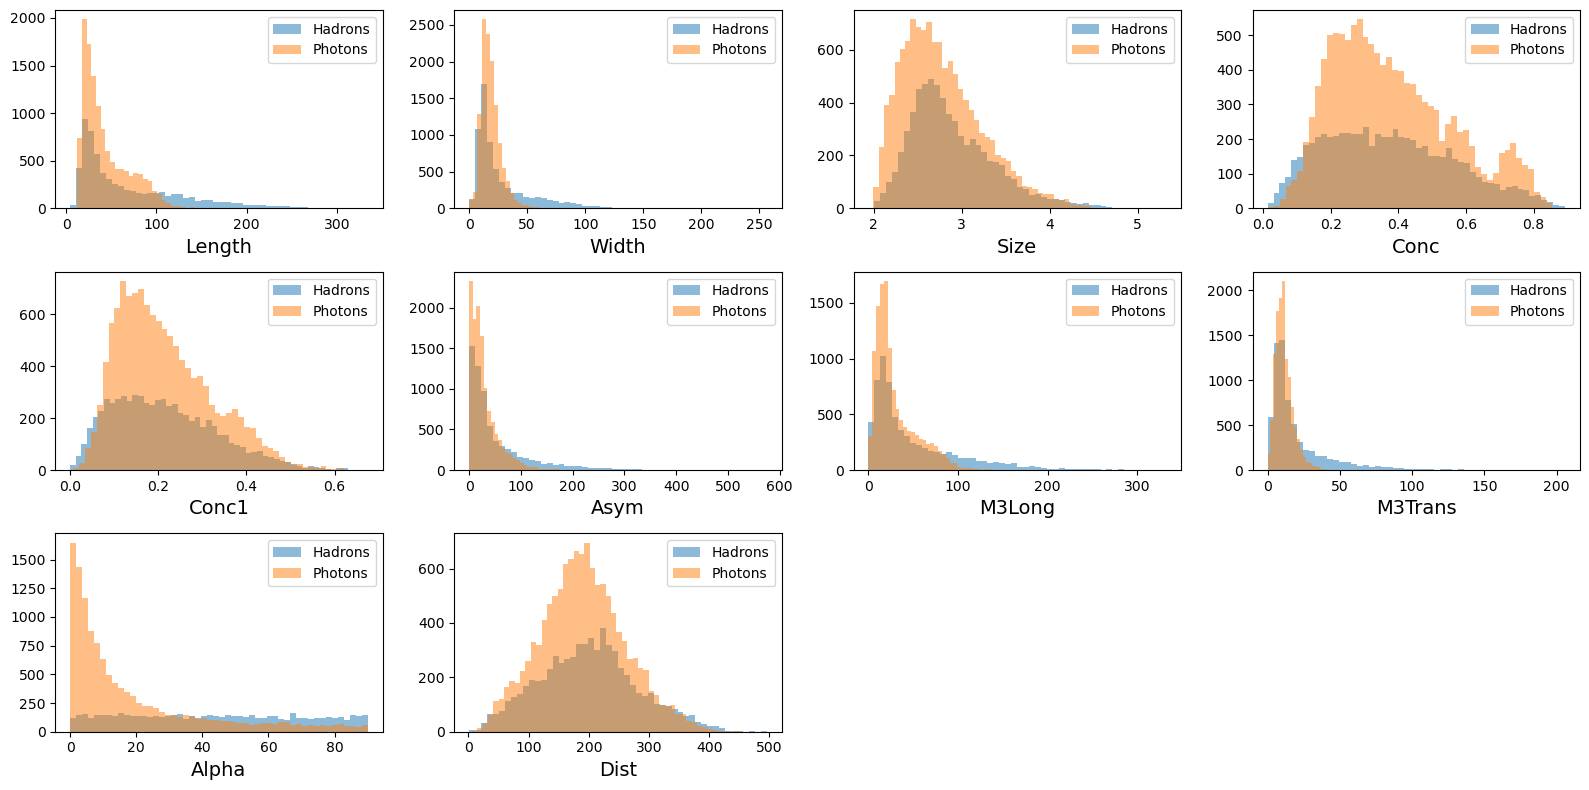

In [74]:
plot_hists(X[y[:, 0]==0], X[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

## Предобработка данных

Из графика видим, что распределения для многих признаков имеют тяжелые хвосты. Это делает обучение генеративных моделей тяжелее. Поэтому, нужно как-то преобразовать данные, чтобы убрать эти тяжелые хвосты. 

### Задание 1 (1 балл)

Используя функцию `sklearn.preprocessing.QuantileTransformer` трансформируйте входные данные `X`. Это преобразование делает так, чтобы распределение каждого параметра было нормальным. Описание функции доступно по ссылке http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html. Используйте значение параметра `output_distribution='normal'`. 

In [75]:
### YOUR CODE IS HERE ######
from sklearn.preprocessing import QuantileTransformer

qt = QuantileTransformer(random_state=42, output_distribution='normal')
X_qt = qt.fit_transform(X)
### THE END OF YOUR CODE ###

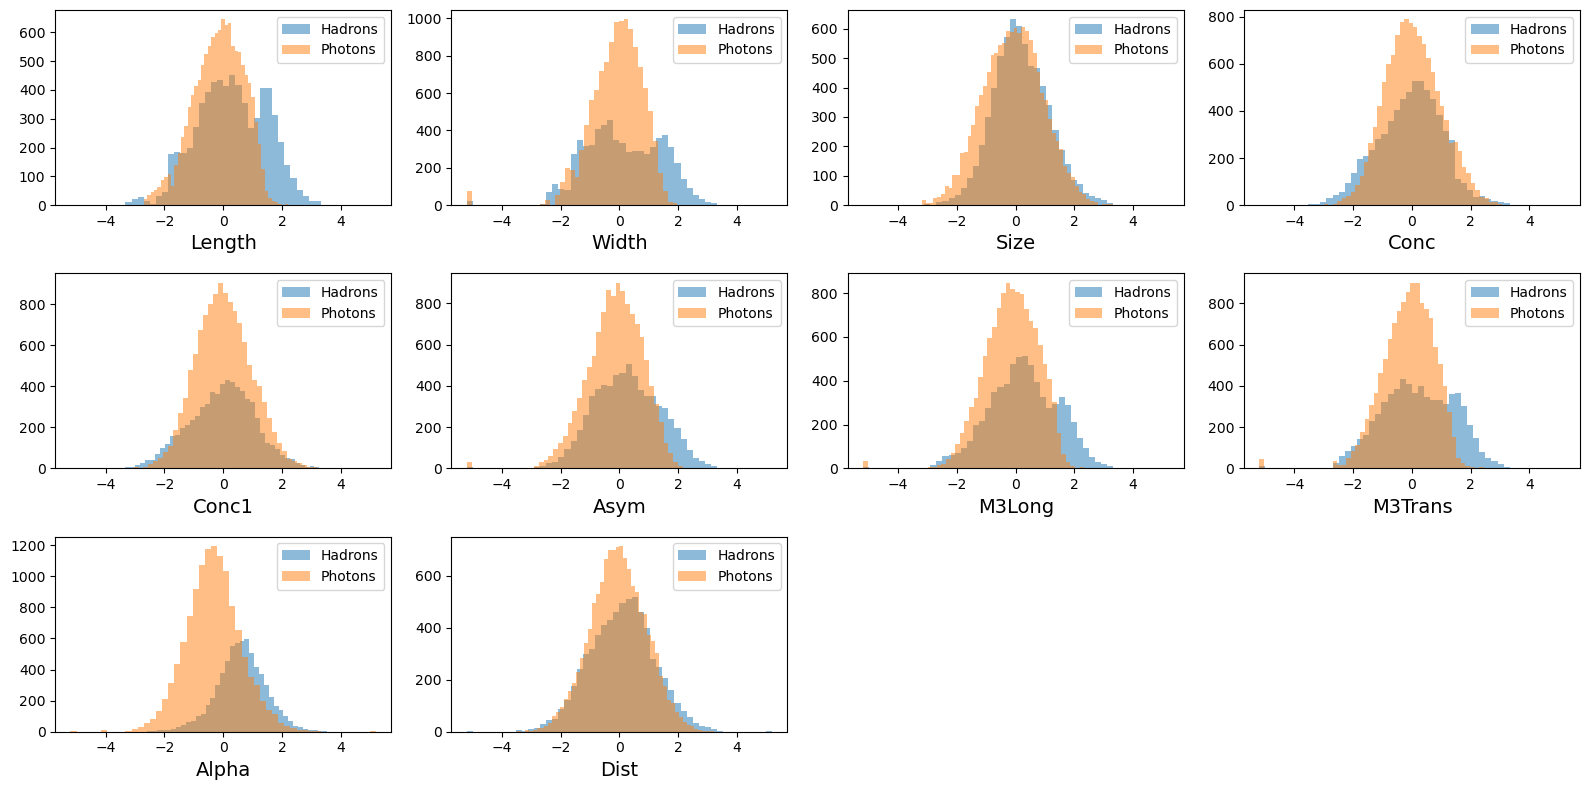

In [76]:
plot_hists(X_qt[y[:, 0]==0], X_qt[y[:, 0]==1], names, label1="Hadrons", label2="Photons", bins=50)

### Обучающая и тестовая выборки

In [86]:
np.unique(y)

array([0., 1.])

In [87]:
from sklearn.model_selection import train_test_split

# train / test split
X_train, X_test, y_train, y_test = train_test_split(X_qt, y, stratify=y, test_size=0.5, shuffle=True, random_state=11)

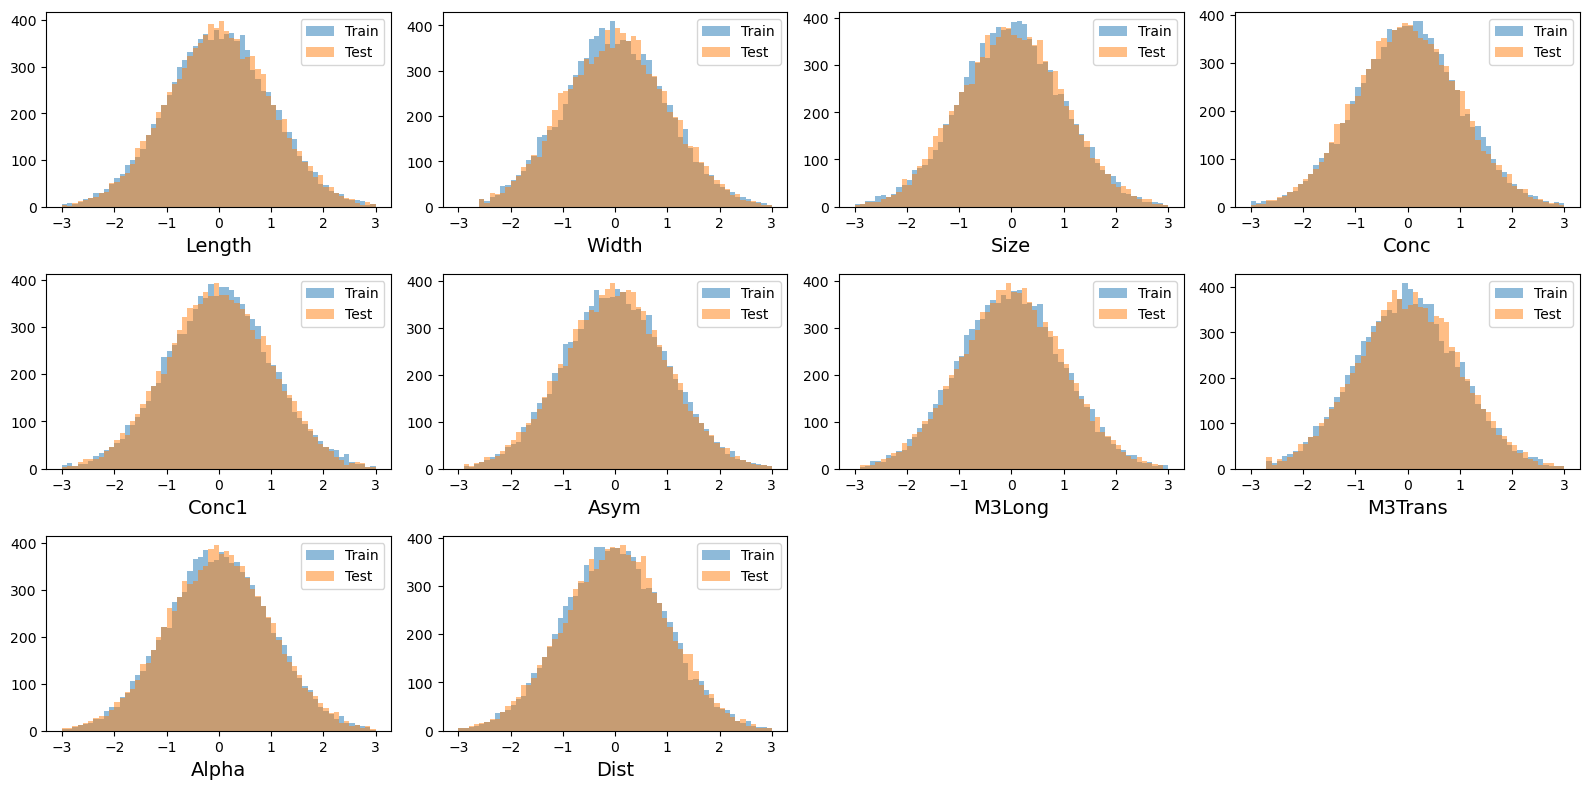

In [88]:
plot_hists(X_train, X_test, names, label1="Train", label2="Test")

# Conditional WGAN

Мы будем использовать `Conditional WGAN`, который изображен на рисунке. В качестве условия `y` мы будем использовать метку класса: **0** - адрон, **1** - фотон. Таким образом, мы будем сообщать генератору для какой частицы нужно генерировать параметры изображения. 

<center><img src="img/cgan.png" width="800"></center>

Генератор $\hat{x} = G(z, y)$ будет принимать на вход шумовой вектор $z$ и вектор условий $y$, а выдавать будет сгенерированный (фейковый) вектор параметров $\hat{x}$. 

Дискриминатор $D(x, y)$ будет принимать на вход вектор параметров $x$ и вектор условий $y$, а возвращать будет рациональное число.

Обучать `Conditional WGAN` будем с такой функцией потерь:

$$L(G, D) = -\frac{1}{n} \sum_{x_i \in X, y_i \in y} D(x_i, y_i) + -\frac{1}{n} \sum_{z_i \in Z, y_i \in y} D(G(z_i, y_i), y_i) \to \max_G \min_D$$

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [96]:
DEVICE

device(type='cpu')

## Задание 2 (1 балл)

Реализуйте нейронную сеть для генератора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой.

Подсказка: используйте функцию `nn.Sequential()`.

In [98]:
class Generator(nn.Module):
    
    def __init__(self, n_inputs, n_outputs):
        super(Generator, self).__init__()
        
        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, n_outputs)
        )
        ### THE END OF YOUR CODE ###

    def forward(self, z, y):
        zy = torch.cat((z, y), dim=1)
        return self.net(zy)

## Задание 3 (1 балл)

Реализуйте нейронную сеть для дискриминатора со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Подсказка: используйте функцию `nn.Sequential()`.

In [99]:
class Discriminator(nn.Module):
    
    def __init__(self, n_inputs):
        super(Discriminator, self).__init__()
        
        ### YOUR CODE IS HERE ######
        self.net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 1),
            nn.Sigmoid()
        )
        ### THE END OF YOUR CODE ###

    def forward(self, x, y):
        xy = torch.cat((x, y), dim=1)
        return self.net(xy)

## Задание 4 (2 балла)

Реализуйте класс для обучения генеративной модели.

- Подсказка 1: не забывайте ограничивать веса дискриминатора. Для этого используйте `p.data.clamp_(-0.01, 0.01)`, где `p` веса дискриминатора.
- Подсказка 2: `n_critic` - число итераций обучения дискриминатора на одну итерацию обучения генератора.
- Подсказка 3: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

array([[ 28.7967,  16.0021,   2.6449, ...,   8.2027,  40.092 ,  81.8828],
       [ 31.6036,  11.7235,   2.5185, ...,   9.9574,   6.3609, 205.261 ],
       [162.052 , 136.031 ,   4.0612, ...,  45.216 ,  76.96  , 256.788 ],
       ...,
       [ 75.4455,  47.5305,   3.4483, ...,   9.4662,  30.2987, 256.5166],
       [120.5135,  76.9018,   3.9939, ...,  63.8389,  84.6874, 408.3166],
       [187.1814,  53.0014,   3.2093, ...,  31.4755,  52.731 , 272.3174]])

In [151]:
class Fitter(object):
    
    def __init__(self, generator, discriminator, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, n_critic=5):
        
        self.generator = generator
        self.discriminator = discriminator
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.n_critic = n_critic
        
        self.opt_gen  = torch.optim.RMSprop(self.generator.parameters(), lr=self.lr)
        self.opt_disc = torch.optim.RMSprop(self.discriminator.parameters(), lr=self.lr)
        
        self.generator.to(DEVICE)
        self.discriminator.to(DEVICE)
    
    
    def fit(self, X, y):
        
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.generator.train(True)
        self.discriminator.train(True)
        
        self.loss_history = []

        # Fit GAN
        for epoch in range(self.n_epochs):

            for i, (real_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                ### YOUR CODE IS HERE ######
                
                # 1. Training Discriminator
                
                ## 1.1 train on real data
                D_r = self.discriminator(real_batch, cond_batch)
                loss_D_real = -torch.mean(D_r)
                
                ## 1.2 train on fake data
                z = torch.normal(0, 1, (len(real_batch), self.latent_dim))
                fake_batch = self.generator(z, cond_batch).detach() # exclude this tensor from the computation graph
                D_f = self.discriminator(fake_batch, cond_batch)
                loss_D_fake = torch.mean(D_f)

                ## 1.3 aggregate loss and backpropagate
                self.opt_disc.zero_grad()
                loss_D = loss_D_real + loss_D_fake
                loss_D.backward()
                self.opt_disc.step()
                
            
                # 2. Train Generator
                if i % self.n_critic == 0:
                    # generate fake input, do not detach it, then optimize
                    z = torch.normal(0, 1, (len(real_batch), self.latent_dim))
                    fake_batch = self.generator(z, cond_batch)
                    D_f = self.discriminator(fake_batch, cond_batch)
                    loss_G_fake = -torch.mean(D_f)

                    D_r = self.discriminator(real_batch, cond_batch)
                    loss_G_real = torch.mean(D_r)

                    # optimization
                    loss_G = loss_G_real + loss_G_fake
                    self.opt_gen.zero_grad()
                    loss_G.backward()
                    self.opt_gen.step()
                    
                ### THE END OF YOUR CODE ###
                    
            # caiculate and store loss after an epoch
            Z_noise = torch.normal(0, 1, (len(X_real), self.latent_dim))
            X_fake = self.generator(Z_noise, y_cond)
            loss_epoch = torch.mean(self.discriminator(X_real, y_cond)) - torch.mean(self.discriminator(X_fake, y_cond))
            self.loss_history.append(loss_epoch.detach().cpu())

            print(f'Epoch {epoch}: ', f'{loss_epoch}')
                    
        # Turn off training
        self.generator.train(False)
        self.discriminator.train(False)

## Обучение
Обучим модель на данных.

In [162]:
%%time
latent_dim = 10
generator     = Generator(n_inputs=latent_dim+y.shape[1], 
                          n_outputs=X_train.shape[1])
discriminator = Discriminator(n_inputs=X_train.shape[1]+y.shape[1])

fitter = Fitter(generator, discriminator, batch_size=50, n_epochs=100, latent_dim=latent_dim, lr=0.0001, n_critic=5)
fitter.fit(X_train, y_train)

Epoch 0:  0.12299209833145142
Epoch 1:  0.06949949264526367
Epoch 2:  0.026940464973449707
Epoch 3:  0.0033165812492370605
Epoch 4:  -0.004240810871124268
Epoch 5:  0.03589051961898804
Epoch 6:  0.026809990406036377
Epoch 7:  0.005453288555145264
Epoch 8:  0.015290617942810059
Epoch 9:  0.04210710525512695
Epoch 10:  0.02297687530517578
Epoch 11:  0.055225253105163574
Epoch 12:  0.03243812918663025
Epoch 13:  0.03806471824645996
Epoch 14:  0.025052964687347412
Epoch 15:  0.024420738220214844
Epoch 16:  0.03212729096412659
Epoch 17:  0.017753154039382935
Epoch 18:  0.023475438356399536
Epoch 19:  0.02700105309486389
Epoch 20:  0.029687166213989258
Epoch 21:  0.02914831042289734
Epoch 22:  0.029416650533676147
Epoch 23:  0.023315846920013428
Epoch 24:  0.020756632089614868
Epoch 25:  0.022710204124450684
Epoch 26:  0.02509257197380066
Epoch 27:  0.030170679092407227
Epoch 28:  0.025970041751861572
Epoch 29:  0.022653847932815552
Epoch 30:  0.02446398138999939
Epoch 31:  0.017654538154602

/tmp/ipykernel_146434/3471976127.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')


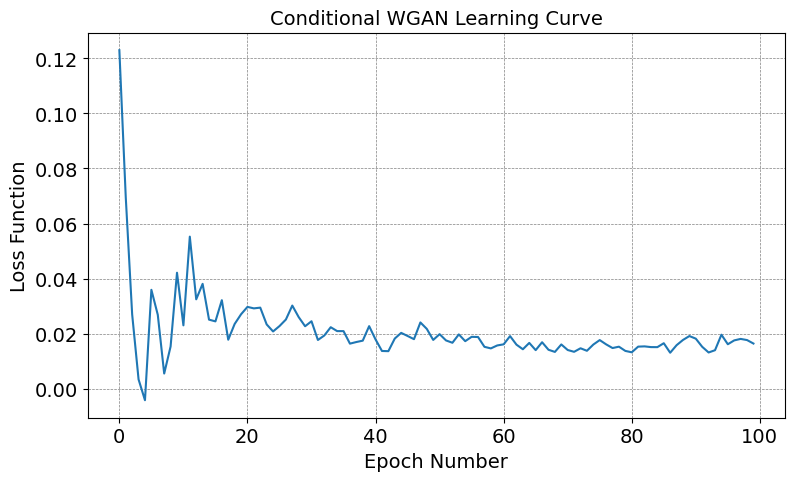

In [163]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional WGAN Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Задание 5 (1 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [164]:
def generate(generator, y, latent_dim):
    ### YOUR CODE IS HERE ######
    Z_noise = torch.normal(0, 1, (len(y), latent_dim)).to(DEVICE)
    X_fake = generator(Z_noise, torch.tensor(y, dtype=torch.float).to(DEVICE)).detach().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake # numpy

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [165]:
X_fake_train = generate(fitter.generator, y_train, latent_dim)

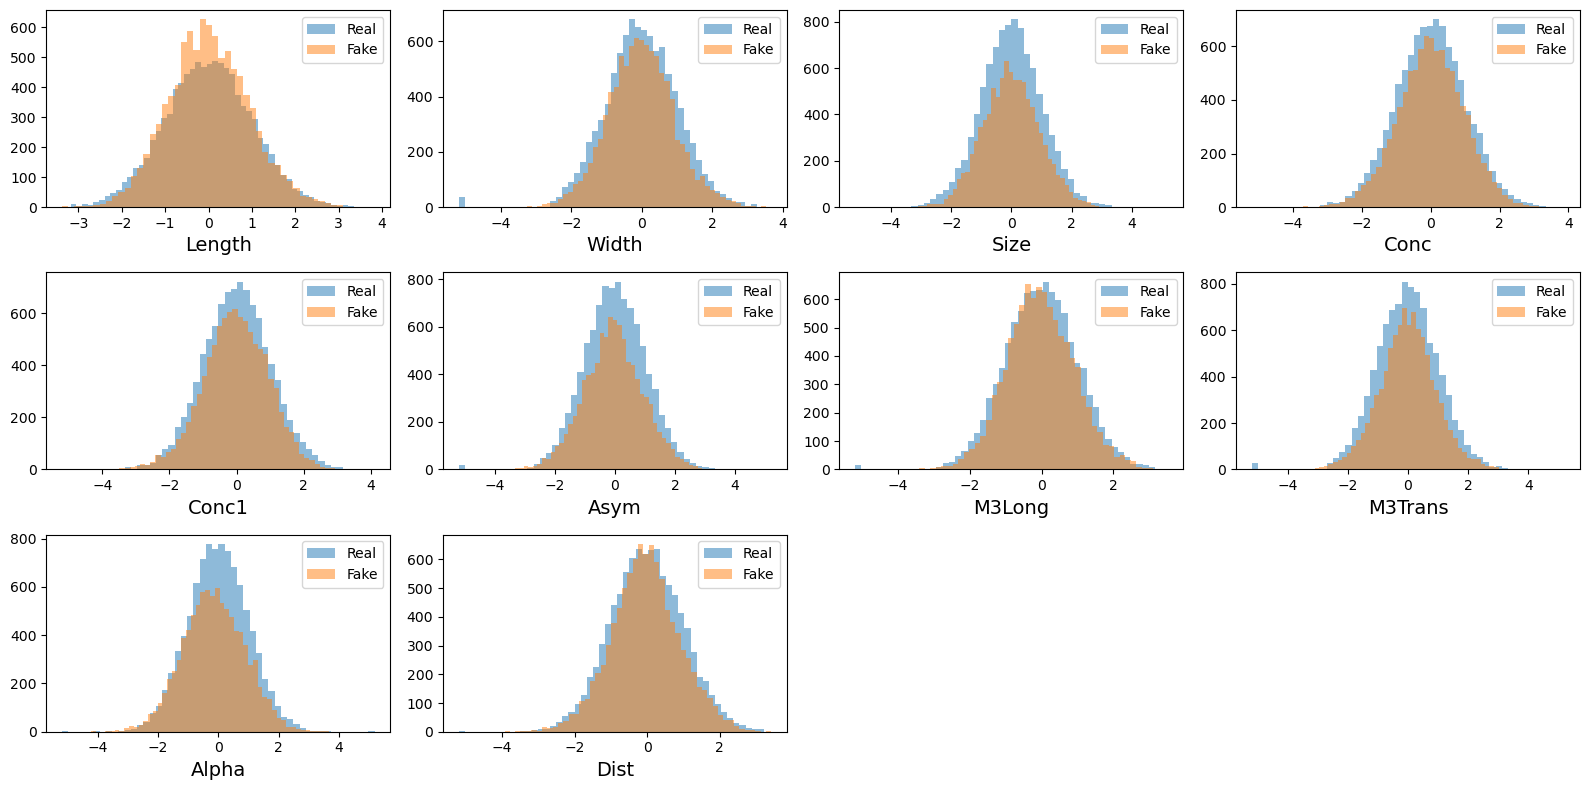

In [166]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [167]:
X_fake_test = generate(fitter.generator, y_test, latent_dim)

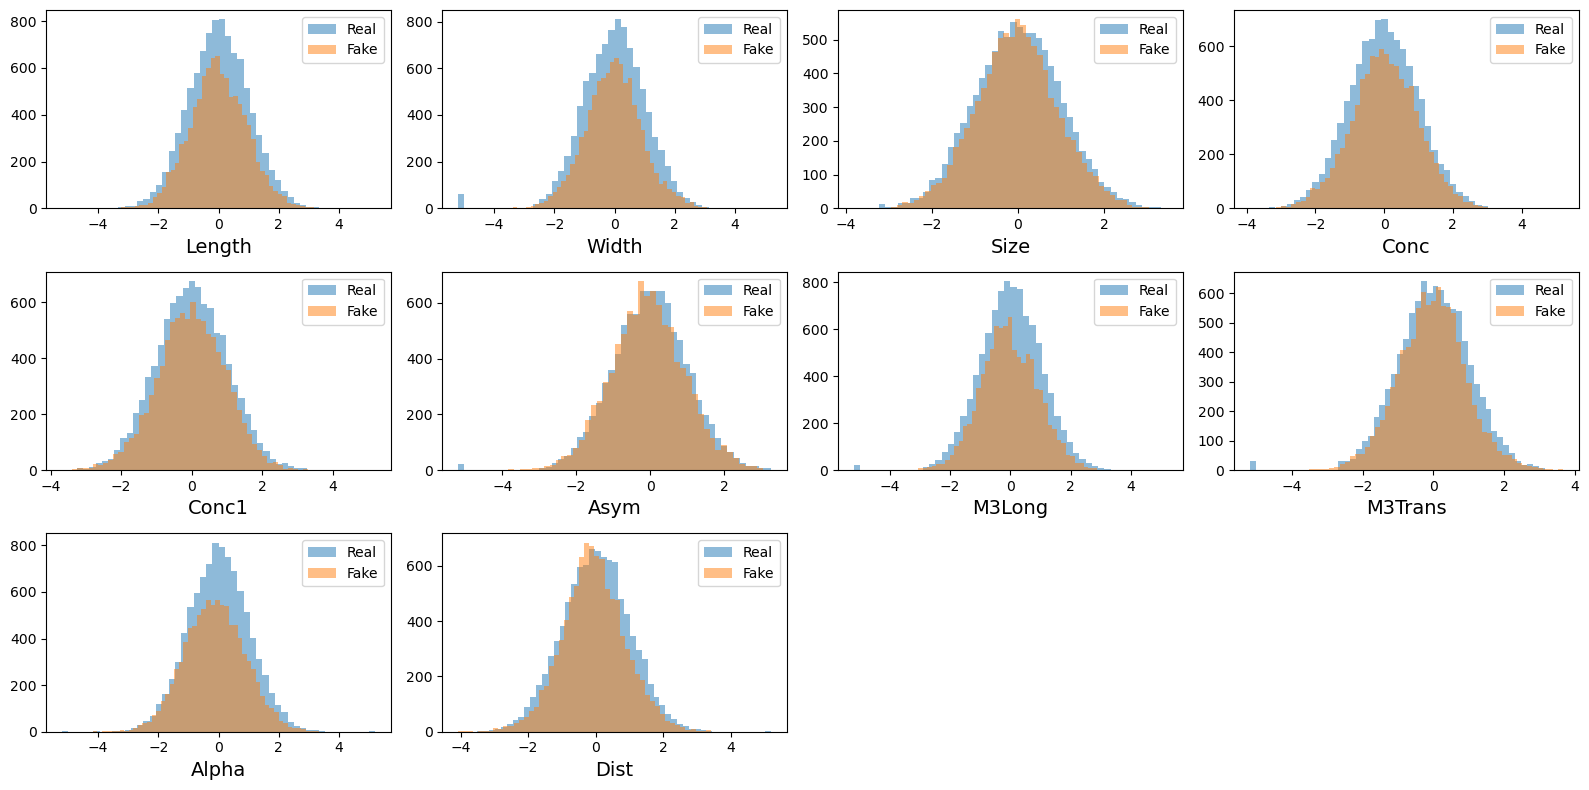

In [168]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

## Вывод 1: 
Визуально мы видим сходство реальных и фейковых данных. Однако это только проекции 10-мерных объектов на одну ось.

## Измерение качества генерации

<center><img src="img/clf.png" width="600"></center>

Измерим сходство распределений классификатором.

In [169]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [170]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [171]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.666648986456229


## Вывод 2

Идеальное значение ROC AUC равно 0.5. Это соответствует случаю, когда классификатор не может разделить реальные и фейковые данные. В нашем случае ROC AUC около 0.7, что говорит о том, что есть куда улучшать качество генеративной модели :)

# Условные вариационные автокодировщики

<center><img src="img/cvae.svg" width="600"></center>

Теперь, решим эту же задачу используя условный автокодировщик (CVAE). Пользуясь вашим семинаром по теме вариационных автокодировщиков выполните следующие задания.

## Задание 6 (1 балл)

Реализуйте нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- Слой батч-нормализации;
- ReLU функцию активации;
- Выходной слой для mu; Выходной слой для log_sigma;

Подсказка: используйте функцию `nn.Sequential()`.

In [181]:
class Encoder(nn.Module):
    def __init__(self, n_inputs, lat_size):
        super(Encoder, self).__init__()
        
        ### YOUR CODE IS HERE ######
        self.enc_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.BatchNorm1d(100),
            nn.ReLU(inplace=True),
        )
        
        self.mu = nn.Linear(100, lat_size)
        self.log_sigma = nn.Linear(100, lat_size)
        ### THE END OF YOUR CODE ###
        
    def forward(self, x, y):
        z = torch.cat((x, y), dim=1)
        z = self.enc_net(z)
        mu = self.mu(z)
        log_sigma = self.log_sigma(z)
        return mu, log_sigma 

## Задание 7 (1 балл)

Реализуйте нейронную сеть для декодеровщика со следующими слоями:
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Полносвязный слой со 100 нейронами;
- ReLU функцию активации;
- Выходной слой.

Подсказка: используйте функцию `nn.Sequential()`.

In [182]:
class Decoder(nn.Module):
    def __init__(self, n_inputs, n_outputs):
        super(Decoder, self).__init__()
        
        ### YOUR CODE IS HERE ######
        self.dec_net = nn.Sequential(
            nn.Linear(n_inputs, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, 100),
            nn.ReLU(inplace=True),
            nn.Linear(100, n_outputs)
        )
        ### THE END OF YOUR CODE ###
        
    def forward(self, z, y):
        z_cond = torch.cat((z, y), dim=1)
        x_rec = self.dec_net(z_cond)
        return x_rec

## Задание 8 (1 балл)

Реализуйте класс для обучения вариационного автокодировщика.

Подсказка: Используйте `X_tensor = torch.tensor(X_numpy, dtype=torch.float, device=DEVICE)` для перевода numpy в тензор.

In [191]:
class VAEFitter(object):
    
    def __init__(self, encoder, decoder, batch_size=32, n_epochs=10, latent_dim=1, lr=0.0001, KL_weight=0.001):
        
        self.encoder = encoder
        self.decoder = decoder
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.latent_dim = latent_dim
        self.lr = lr
        self.KL_weight = KL_weight
        
        self.criterion = nn.MSELoss()
        self.opt  = torch.optim.RMSprop(list(self.encoder.parameters()) + list(self.decoder.parameters()), lr=self.lr)
        
        self.encoder.to(DEVICE)
        self.decoder.to(DEVICE)
        
        
    def sample_z(self, mu, log_sigma):
        eps = torch.randn(mu.shape).to(DEVICE)
        return mu + torch.exp(log_sigma / 2) * eps
    
    def custom_loss(self, x, rec_x, mu, log_sigma):
        KL = torch.mean(-0.5 * torch.sum(1 + log_sigma - mu ** 2 - log_sigma.exp(), dim = 1), dim = 0)
        recon_loss = self.criterion(x, rec_x)
        return KL*self.KL_weight + recon_loss
    
    
    def compute_loss(self, x_batch, cond_batch):
        
        ### YOUR CODE IS HERE ######
        mu, log_sigma = self.encoder(x_batch, cond_batch)
        z_batch = self.sample_z(mu, log_sigma)
        x_rec = self.decoder(z_batch, cond_batch)

        loss = self.custom_loss(x_batch, x_rec, mu, log_sigma)
        ### THE END OF YOUR CODE ###
        
        return loss
    
    
    def fit(self, X, y):
        
        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        # Turn on training
        self.encoder.train(True)
        self.decoder.train(True)
        
        self.loss_history = []

        # Fit VAE
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                
                # calculate loss
                loss = self.compute_loss(x_batch, cond_batch)
                
                # optimization step
                self.opt.zero_grad()
                loss.backward()
                self.opt.step()
                    
            # calculate and store loss after an epoch
            loss_epoch = self.compute_loss(X_real, y_cond)
            self.loss_history.append(loss_epoch.detach().cpu())

            print(f'Epoch {epoch}: ', f'Loss: {loss_epoch}')
                    
        # Turn off training
        self.encoder.train(False)
        self.decoder.train(False)

## Обучение
Обучим модель на данных.

In [192]:
%%time

latent_dim = 10

encoder = Encoder(n_inputs=X_train.shape[1]+y.shape[1], lat_size=latent_dim)
decoder = Decoder(n_inputs=latent_dim+y.shape[1], n_outputs=X_train.shape[1])

vae_fitter = VAEFitter(encoder, decoder, batch_size=50, n_epochs=100, latent_dim=latent_dim, lr=0.001, KL_weight=0.001)
vae_fitter.fit(X_train, y_train)

Epoch 0:  Loss: 0.11354520171880722
Epoch 1:  Loss: 0.08979849517345428
Epoch 2:  Loss: 0.19919054210186005
Epoch 3:  Loss: 0.08955220878124237
Epoch 4:  Loss: 0.08342237770557404
Epoch 5:  Loss: 0.06944896280765533
Epoch 6:  Loss: 0.09196832776069641
Epoch 7:  Loss: 0.11767501384019852
Epoch 8:  Loss: 0.0650007501244545
Epoch 9:  Loss: 0.14132781326770782
Epoch 10:  Loss: 0.06099892780184746
Epoch 11:  Loss: 0.05602147430181503
Epoch 12:  Loss: 0.049640048295259476
Epoch 13:  Loss: 0.05785246565937996
Epoch 14:  Loss: 0.10419590771198273
Epoch 15:  Loss: 0.07836896181106567
Epoch 16:  Loss: 0.12827301025390625
Epoch 17:  Loss: 0.08228877931833267
Epoch 18:  Loss: 0.06477266550064087
Epoch 19:  Loss: 0.07460097968578339
Epoch 20:  Loss: 0.06250365078449249
Epoch 21:  Loss: 0.19994421303272247
Epoch 22:  Loss: 0.08861760795116425
Epoch 23:  Loss: 0.05943481624126434
Epoch 24:  Loss: 0.07597554475069046
Epoch 25:  Loss: 0.0965297520160675
Epoch 26:  Loss: 0.098130002617836
Epoch 27:  Los

/tmp/ipykernel_146434/2405274449.py:9: MatplotlibDeprecationWarning: The 'b' parameter of grid() has been renamed 'visible' since Matplotlib 3.5; support for the old name will be dropped two minor releases later.
  plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')


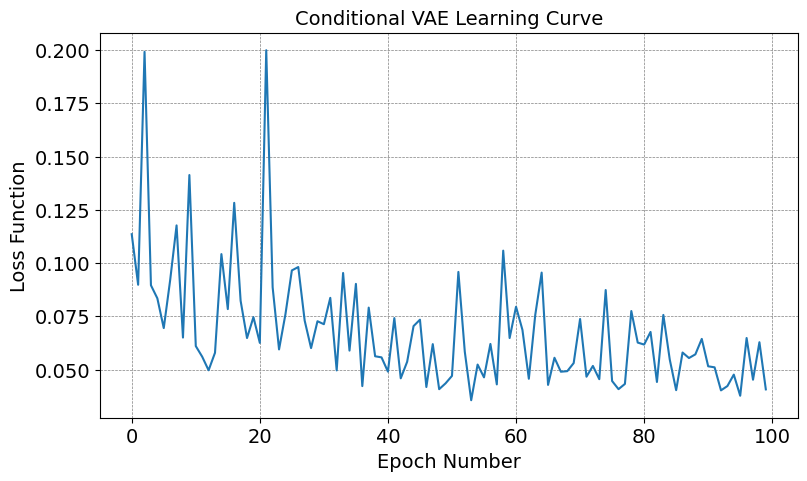

In [193]:
# WGAN learning curve
plt.figure(figsize=(9, 5))
plt.plot(vae_fitter.loss_history)
plt.xlabel("Epoch Number", size=14)
plt.ylabel("Loss Function", size=14)
plt.xticks(size=14)
plt.yticks(size=14)
plt.title("Conditional VAE Learning Curve", size=14)
plt.grid(b=1, linestyle='--', linewidth=0.5, color='0.5')
plt.show()

## Задание 9 (1 балл)

Реализуйте функцию для генерации новый объектов $X$ по вектору условий $y$.

In [216]:
def generate(decoder, y, latent_dim):
    ### YOUR CODE IS HERE ######
    z = torch.normal(0, 1, (len(y), latent_dim)).to(DEVICE)
    X_fake = decoder(z, torch.tensor(y, dtype=torch.float).to(DEVICE)).detach().numpy()
    ### THE END OF YOUR CODE ###
    return X_fake # numpy

Теперь сгенерируем фейковые матрицы `X_fake_train` и `X_fake_test`. Сравним их с матрицами реальных объектов `X_train` и `X_test`

In [217]:
X_fake_train = generate(vae_fitter.decoder, y_train, latent_dim)

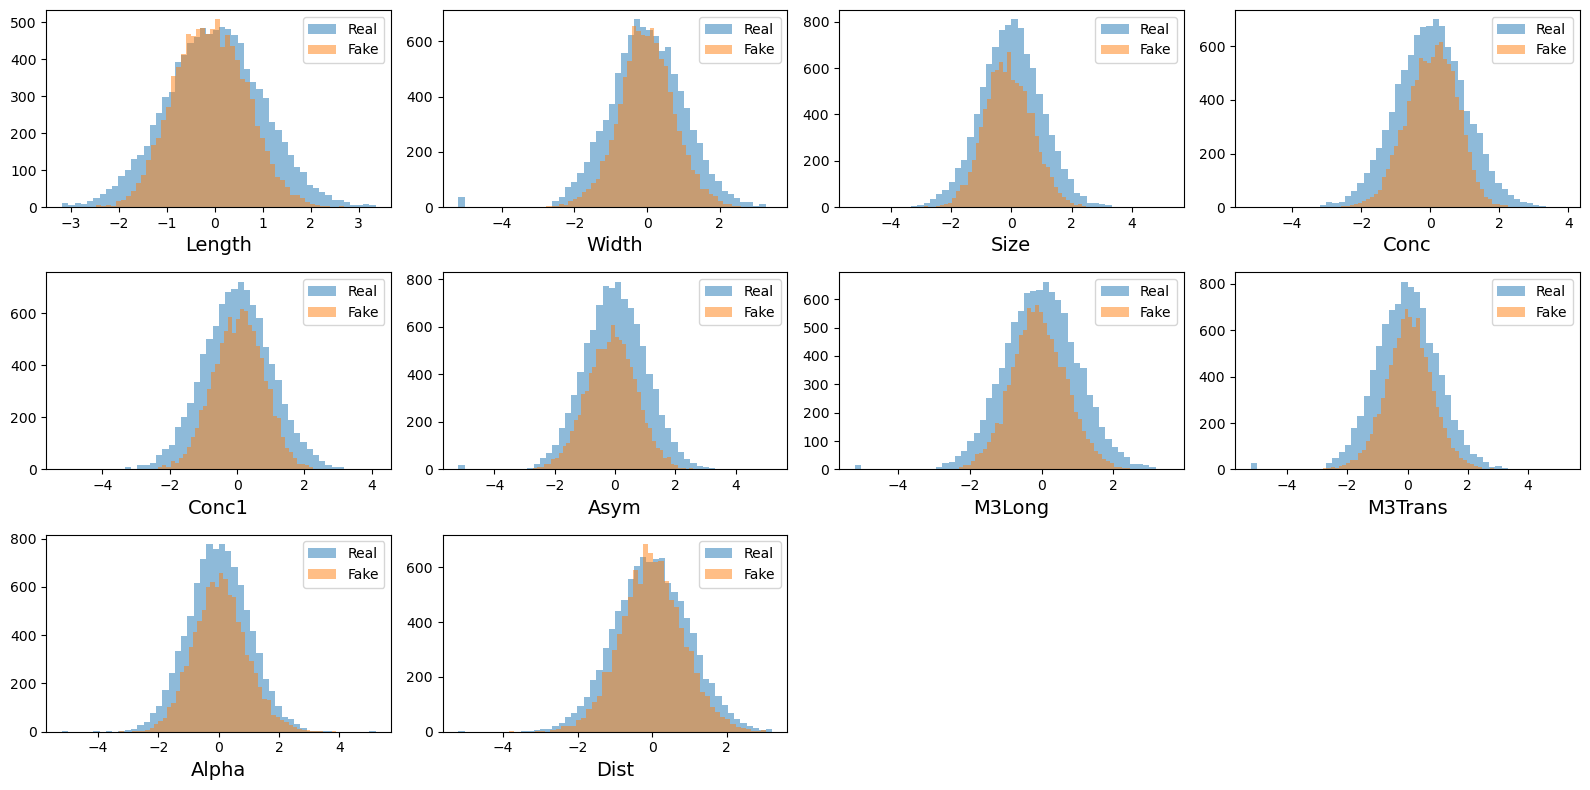

In [218]:
plot_hists(X_train, X_fake_train, names, label1="Real", label2="Fake", bins=50)

In [219]:
X_fake_test = generate(vae_fitter.decoder, y_test, latent_dim)

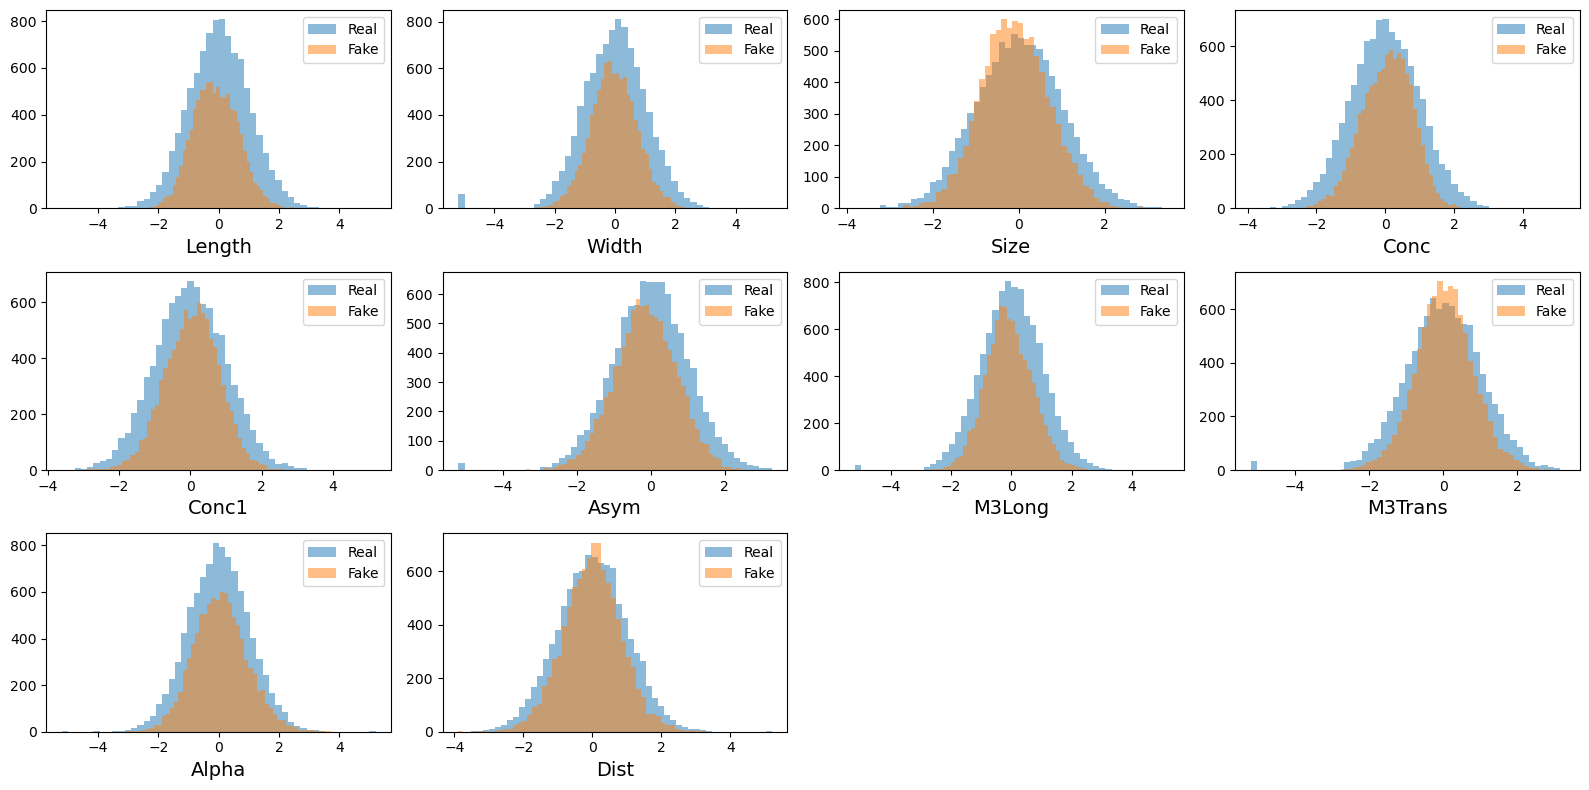

In [220]:
plot_hists(X_test, X_fake_test, names, label1="Real", label2="Fake", bins=50)

# Измерение качества генерации

Измерим сходство распределений классификатором.

In [221]:
# собираем реальный и фейковые матрицы в одну
XX_train = np.concatenate((X_fake_train, X_train), axis=0)
XX_test = np.concatenate((X_fake_test, X_test), axis=0)

yy_train = np.array([0]*len(X_fake_train) + [1]*len(X_train))
yy_test = np.array([0]*len(X_fake_test) + [1]*len(X_test))

In [222]:
from sklearn.ensemble import GradientBoostingClassifier

# обучаем классификатор
clf = GradientBoostingClassifier()
clf.fit(XX_train, yy_train)

# получаем прогнозы
yy_test_proba = clf.predict_proba(XX_test)[:, 1]

In [223]:
from sklearn.metrics import roc_auc_score

auc = roc_auc_score(yy_test, yy_test_proba)
print("ROC AUC = ", auc)

ROC AUC =  0.6976624251852884


## Задание 10 (3 балла)

Для CVAE получили ROC AUC около 0.7 (меньше лучше). Таким образом видим, что в данной задаче обе модели ведут себя схожим образом. Но может их можно как-то улучшить? Попробуйте обучить любой вид нормализационного потока для решения этой задачи.

<center><img src="img/mem1.jpg" width="500"></center>

<center><img src="img/mem2.jpg" width="500"></center>

Восстановим семинар по нормпотокам IAD 2022: https://github.com/hse-ds/iad-applied-ds/tree/master/2022/seminars/sem04

Абстрактные классы для блока нормпотока `InvertibleLayer` и для всего нормпотока `NormalizingFlow` можно определить следующим образом.

У блока `InvertibleLayer` должны быть определены две функции:

* `def f(self, x)`, которая делает прямое преобразование и возращает два значения: $f(x)$ и $ \log \big| \det \big(\frac{\delta f(x)}{x} \big) \big|$
* `def g(self, x)`, которая делает обратное преобразование и возвращает одно значение: $f^{-1}(x)$

Чтобы проверить, что ваш код написан правильно, используйте функции `check_inverse` и `check_log_det` для проверки обратимости слоя и для проверки правильности подсчета $ \log \big| \det \big(\frac{\delta f(x)}{x} \big) \big|$

In [5]:
# your code here
class InvertibleLayer(nn.Module):
  def __init__(self, var_size):
    super(InvertibleLayer, self).__init__()

    self.var_size = var_size

  def f(self, x):
    '''
    Implementation of forward pass.
    
    x: torch.Tensor of shape [batch_size, var_size]

    Return:
      torch.Tensor of shape [batch_size, var_size], torch.Tensor of shape [batch_size]
    '''
    pass

  def g(self, x):
    '''
    Implementation of backward (inverse) pass.

    x: torch.Tensor of shape [batch_size, var_size]
    
    Return:
    А  torch.Tensor of shape [batch_size, var_size]
    '''
    pass

  def check_inverse(self):
    '''
    Perform check of invertibility.
    '''
    x = torch.randn(10, self.var_size)

    assert torch.norm(x - self.g(self.f(x)[0])).item() < 0.001

  def check_log_det(self):
    '''
    Perform check of log determinant.
    '''
    x = torch.randn(1, self.var_size).requires_grad_()
    _, log_det = self.f(x)

    jac = torch.autograd.functional.jacobian(lambda x: self.f(x)[0], x)
    assert torch.abs(log_det - torch.log(torch.det(jac[0, :, 0, :]))).item() < 0.001

In [6]:
class NormalizingFlow(nn.Module):
  def __init__(self, layers, prior):
    super(NormalizingFlow, self).__init__()

    self.layers = nn.ModuleList(layers)
    self.prior = prior

  def log_prob(self, x):
    log_likelihood = None

    for layer in self.layers:
      x, change = layer.f(x)
      if log_likelihood is not None:
        log_likelihood = log_likelihood + change
      else:
        log_likelihood = change
    log_likelihood = log_likelihood + self.prior.log_prob(x)

    return log_likelihood.mean()

  def sample(self, num_samples):
    x = self.prior.sample((num_samples, ))

    for layer in self.layers[::-1]:
      x = layer.g(x)

    return x

In [3]:
class NormFlowFitter(object):
    
    def __init__(self, layers, prior, batch_size=32, n_epochs=10, lr=1e-3, device='cuda'):
        
        self.device = device

        self.layers = layers
        self.prior = prior
        self.nf = NormalizingFlow(self.layers, self.prior).to(self.device)

        self.lr = lr
        self.batch_size = batch_size
        self.n_epochs = n_epochs
        self.opt = torch.optim.Adam(self.nf.parameters(), lr=self.lr)
                  
    
    def fit(self, X, y):
        self.nf.train()

        # numpy to tensor
        X_real = torch.tensor(X, dtype=torch.float, device=DEVICE)
        y_cond = torch.tensor(y, dtype=torch.float, device=DEVICE)
        
        # tensor to dataset
        dataset_real = TensorDataset(X_real, y_cond)
        
        self.loss_history = []

        # Fit VAE
        for epoch in range(self.n_epochs):
            for i, (x_batch, cond_batch) in enumerate(DataLoader(dataset_real, batch_size=self.batch_size, shuffle=True)):
                x_batch, cond_batch = x_batch.to(self.device), cond_batch.to(self.device)
                
                self.opt.zero_grad()
                
                # calculate loss
                loss = -self.nf.log_prob(x_batch)

                # optimization step
                loss.backward()
                self.opt.step()
                # self.loss_history.append(loss.item())
                    
            # calculate and store loss after an epoch
            X_real = X_real # torch.cat((X_real, y_cond), dim=1)
            loss_epoch = self.nf.log_prob(X_real)
            self.loss_history.append(loss_epoch.detach().cpu())

            print(f'Epoch {epoch}: ', f'Loss: {loss_epoch}')
                    
        # Turn off training
        self.nf.train(False)

    def sample(self, n):
        return self.nf.sample(n)

In [20]:
class ActNorm(InvertibleLayer):
  def __init__(self, var_size):
    super(ActNorm, self).__init__(var_size=var_size)
    
    # model w as torch.exp(self.log_w)
    self.log_w = nn.Parameter(torch.randn(var_size))
    self.bias = nn.Parameter(torch.zeros(var_size))

    self.initialized = False

  def f(self, x):
    if not self.initialized:
      self.bias.data = -x.mean(dim=0)
      self.log_w.data = -torch.log(x.std(dim=0) + 1e-1)
      self.initialized = True

    new_x = torch.exp(self.log_w[None, :]) * x + self.bias
    log_det = self.log_w.sum()
    return new_x, log_det

  def g(self, x):
    return torch.exp(-self.log_w[None, :]) * (x - self.bias)

class InvNonlin(InvertibleLayer):
  def __init__(self, var_size):
    super(InvNonlin, self).__init__(var_size=var_size)

  def f(self, x):
    mask = (torch.abs(x) < 1).float()
    pow = 3 * mask + 1 * (1 - mask)

    signs = torch.sign(x)
    new_x = signs * ((x * signs) ** pow)

    log_det = torch.log((3 * (x**2)) * mask + (1 - mask)).sum(dim=-1)

    return new_x, log_det

  def g(self, x):
    mask = (torch.abs(x) < 1).float()
    pow = (1./3) * mask + 1 * (1 - mask)

    signs = torch.sign(x)
    new_x = signs * ((x * signs) ** pow)

    return new_x

Проверим, что мы правильно реализовали наш код.

In [2]:
layer = ActNorm(var_size=10)
layer.check_inverse()
layer.check_log_det()

layer = InvNonlin(var_size=10)
layer.check_inverse()
layer.check_log_det()

NameError: name 'ActNorm' is not defined

Накидаем несколько обратимых слоев и попробуем обучить.

In [ ]:
prior = torch.distributions.MultivariateNormal(torch.zeros(10).cuda(), torch.eye(10).cuda())

layers = []
for i in range(9):
  if i % 2 == 0:
    layers.append(ActNorm(2))
  else:
    layers.append(InvNonlin(2))

In [ ]:
norm_flow = NormFlowFitter(layers, prior, batch_size=64, n_epochs=50)

# Бонус (1 балл)

Попробуйте настроить параметры обучения каждой модели или еще как-нибудь их улучшить, чтобы получить как можно меньший ROC AUC. Что получилось? Какая модель лучше? 

In [ ]:
# your code here